(content:references:spectra_part5)=
# Stellar Spectra Part 5: *Domain Transfer*

***Author: Marc Hon***

In this Section, we will explore a case study of using machine learning to bridge the gap between theory and observation.

## The Synthetic Gap

Synthetic spectra often fail to perfectly reproduce real stellar observations. This mismatch is known as the **synthetic gap**, and it arises from several limitations:

- Incomplete or uncertain atomic/molecular data, including oscillator strengths

- Not all spectral lines are well characterized from laboratory experiments.

- Molecular bands in cool stars (e.g., CN) can be especially difficult to model accurately.

- Simplifying assumptions in theoretical spectra, such one-dimensional static atmospheres, hydrostatic equilibrium, and Local Thermodynamic Equibrium (LTE). Non-LTE effects such as convection, rotation, and magnetic fields that alter line shapes and strengths are not simulated.

```{note} 

Local Thermodynamic Equilibrium (LTE) is the idea that the population of atomic energy levels is determined solely by the local temperature. In other words, this is as if each layer of the star were in perfect thermal balance and can be described a single, well-defined temperature. This allows us to use familiar thermodynamic laws (like the Boltzmann and Saha equations) to describe atomic populations and line formation, even though the overall atmosphere is not in full equilibrium.


In reality, stellar atmospheres can deviate from LTE, particularly in cases where radiation governs atomic excitation and ionization instead of collisions. This may affect line strengths and shapes, such that models assuming LTE misrepresent key spectral features.

```


- Emission lines and line core fillings due to chromospheric heating (e.g., in [](content:references:spectra_part4)) are not included 

- Real observations are affected by noise, resolution, and telluric contamination, which are difficult to replicate in models.

```{figure} images/arcturus.png
---
height: 420px
width: 700px
name: arcturus
---
Observed (black) and calculated (red) spectra for Arcturus from [Heiter et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015PhyS...90e4010H/abstract). The observed features are mostly replicated by the calculations, except in several places at which the calculated lines are too weak or completely missing, indicative of the synthetic gap.
```

## A Data-driven Approach to Bridge the Gap 

To mitigate effects of the synthetic gap, the [`Cycle-StarNet`](https://github.com/teaghan/Cycle_SN) machine learning framework was designed to freely convert spectral observations between the synthetic and observed domain. The method is based on Generative Adversarial Network (GAN) approaches for image-to-image translation and domain adaptation, including [`CycleGAN`](https://github.com/junyanz/CycleGAN) and [`UNIT` (Unsupervised Image-to-Image Translation Networks)](https://github.com/mingyuliutw/UNIT).


```{admonition} CycleGAN
:class: seealso
At its essence, the CycleGAN architecture comprises two generator networks and two discriminator networks:

- The **generators** learn to translate data between two domains: one maps from domain A to domain B, and the other from B to A.

- The **discriminators** evaluate whether a given image belongs to the true data distribution of each domain or is a generated (translated) image.

A key innovation in CycleGAN is the introduction of **cycle consistency**: if an image is translated to the other domain and then translated back, the result should closely resemble the original. This constraint ensures that the generators do more than just produce realistic outputs; they must also preserve the underlying content or structure during translation, even without paired training examples.

```{figure} images/CycleGAN.png
---
height: 300px
width: 800px
name: cyclegan
---
Schematic of CycleGAN. Image source: [PyImageSearch](https://pyimagesearch.com/2022/09/12/cyclegan-unpaired-image-to-image-translation-part-1/)


```

### Cycle-StarNet: Generators


```{figure} images/CycleStarNet1.png
---
height: 400px
width: 450px
name: cyclestarnet1
---
Schematic of the generative architecture for `Cycle-StarNet`.

```

**Key Points**

- Encoder-latent space-decoder ($E-\mathcal{Z}-D$) architectures exist for each **observed** ($\chi_{obs}$) and **synthetic** ($\chi_{synth}$) domains.

- *The Payne*, a neural network, provides a differentiable spectral generator in the synthetic domain.

- There is a **shared** ($_{sh}$) and **split** ($_{sp}$) component for each $E-\mathcal{Z}-D$ architecture.
    - The split components encode and recinstruct information that is unique to the observed domain such as instrumental noise, telluric contamination, and spectral resolution differences in the observed spectra.
    - The shared components ideally encode and reconstruct astrophysical information common to both domains, which are spectral features like absorption and emission.
    - The latent space $\mathcal{Z}_{sh}$ enforces that encoders from both domains must extract and preserve only the astrophysically meaningful, **domain-invariant** structure of the spectrum.

- `Cycle-StarNet` performs the following reconstructions:
    - $\chi_{synth \rightarrow synth}$ : synthetic domain autoencoding
    - $\chi_{obs \rightarrow obs}$: observational domain autoencoding
    - $\chi_{synth \rightarrow obs}$: translating synthetic spectra to their observed forms
    - $\chi_{obs \rightarrow synth}$: translating observed spectra to their synthetic forms



### Cycle-StarNet: Discriminators


```{figure} images/CycleStarNet2.png
---
height: 300px
width: 450px
name: cyclestarnet2
---
Schematic of the discriminative architecture for `Cycle-StarNet`.

```

Each domain's discriminator $C$ serves to identify which reconstruction actually belongs to a cross-domain translation as opposed to a within-domain reconstruction.

Crucially, the discriminator also uses the shared latent space representations of inputs from both domains (i.e., $\mathcal{Z}_{sh, synth}$ and $\mathcal{Z}_{sh, obs}$) to make its classification. This encourages the cross-domain generators to create both spectral reconstructions and latent representations that can fool the discriminator. By having similar latent representations, there exists semantic alignment of the encoded astrophysical information across domains.

### Cycle-StarNet: Losses

The total loss function $\mathcal{L}$ comprises the following :

- $\mathcal{L}_{rec}$: within-domain mean squared error reconstruction loss for both $\chi_{synth}$ and $\chi_{obs}$
- $\mathcal{L}_{adv}$: domain transfer loss in the form of binary cross-entropy for both $C_{synth}$ and $C_{obs}$
- $\mathcal{L}_{cr}$: cycle reconstruction loss (mean squared error) for the following cross-domain reconstructions
    - $\chi_{obs \rightarrow synth \rightarrow obs}$
    - $\chi_{synth \rightarrow obs \rightarrow synth}$


```{admonition} The Necessity of Cycle Consistency
:class: tip

The GAN loss encourages the generator to produce outputs that are indistinguishable from the target domain. However, this only ensures that the generator produces an output that came from the target domain, with no guarantee that it has **preserved** information from the home domain of the input. 

Cycle consistency enforces **invertibility**, such that $\chi_{obs \rightarrow synth \rightarrow obs}$ retains information about $\chi_{obs}$, and similarly $\chi_{synth \rightarrow obs \rightarrow synth}$ retains information about $\chi_{synth}$.

```

```{important} 
The adversarial loss $\mathcal{L}_{adv}$ involves training domain-specific discriminators ($C_{{synth}}$, $C_{{obs}}$) to distinguish between real and translated spectra.

**Question**:  
When training $C_{{synth}}$, what label should be assigned to each class?

- A) Assign label `1` to $\chi_{{obs} \rightarrow {synth}}$, and label `0` to $\chi_{{synth}}$
- B) Assign label `1` to $\chi_{{synth}}$, and label `0` to $\chi_{{obs} \rightarrow {synth}}$
- C) Assign label `1` to both, since both live in the synthetic domain
- D) Assign label `0.5` to encourage uncertain classification


:::{admonition} Answer
:class: dropdown

**Correct Answer: B)**

The discriminator $C_{{synth}}$ is trained to:

- Output **`1` for real synthetic spectra** ($\chi_{{synth}}$)
- Output **`0` for fake synthetic spectra**, i.e., observed spectra that have been translated to the synthetic domain ($\chi_{{obs} \rightarrow {synth}}$)

This setup allows the generator for the observed $\rightarrow$ synthetic transformation to learn from its mistakes: if $C_{{synth}}$ successfully detects a fake, the generator is penalized, and its parameters are adjusted to produce more realistic translations.

:::

```
## Visualizing Reconstructions

Next, let's examine the spectral reconstructions of a pre-trained version of `Cycle-StarNet`. The implementation here closely follows the example demonstrated by the [official repo](https://github.com/teaghan/Cycle_SN). The following lists the network architecture:

In [1]:
import os, sys, torch, configparser
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from copy import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from torch import nn

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter2' / 'data'
script_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter2' / 'scripts'
sys.path.insert(0, str(script_folder_path))

plt.style.use('science')

fs = 18
from network import CycleSN
from training_fns import create_synth_batch, CSNDataset
from analysis_fns import apstarwavegrid, plot_spec_resid_density, tsne_domain_analysis2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from contextlib import redirect_stdout
import io

model_name = 'kurucz_to_apogee_1'

# Directories
csn_dir = '..'
config_dir = str(data_folder_path) + '/csn_config/'
model_dir = str(data_folder_path) + '/csn_models'
data_dir = str(data_folder_path)

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']

# Data Files
data_file_obs = data_dir + '/csn_apogee_test.h5'
spectra_norm_file = data_dir + '/mean_and_std_PAYNE_specs.npy'
emulator_fn = os.path.join(model_dir, config['DATA']['emulator_fn'])

# Defining Model and Loading Pre-trained Weights into it"
model = CycleSN(architecture_config, emulator_fn, use_cuda=0)
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
print(model.load_state_dict(checkpoint['cycle_model']))

buffer = io.StringIO()

with redirect_stdout(buffer):
    print('\nSynthetic Emulator:\n', model.emulator)
    print('\nEncoder_synth and Encoder_obs :\n', model.encoder_synth)
    print('\nEncoder_sh :\n', model.encoder_sh)
    if model.use_split:
        print('\nEncoder_sp :\n', model.encoder_sp)
        print('\nDecoder_sp :\n', model.decoder_sp)
    print('\nDecoder_sh :\n', model.decoder_sh)
    print('\nDecoder_synth and Decoder_obs :\n', model.decoder_synth)
    print('\nDiscrim_synth and Discrim_obs :\n', model.discriminator_synth)

_summary = buffer.getvalue()
buffer.close()
from IPython.display import Markdown
Markdown(f"```\n{_summary}\n```")

<All keys matched successfully>


```

Synthetic Emulator:
 Sequential(
  (0): Linear(in_features=25, out_features=300, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=300, out_features=7214, bias=True)
)

Encoder_synth and Encoder_obs :
 Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(4,))
  (3): LeakyReLU(negative_slope=0.1)
)

Encoder_sh :
 Sequential(
  (0): Conv1d(64, 128, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(128, 256, kernel_size=(7,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(256, 512, kernel_size=(7,), stride=(2,))
  (5): LeakyReLU(negative_slope=0.1)
  (6): Conv1d(512, 25, kernel_size=(1,), stride=(1,))
  (7): InstanceNorm1d(25, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)

Encoder_sp :
 Sequential(
  (0): Conv1d(64, 32, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(32, 32, kernel_size=(7,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(32, 32, kernel_size=(7,), stride=(2,))
  (5): LeakyReLU(negative_slope=0.1)
  (6): Conv1d(32, 4, kernel_size=(1,), stride=(1,))
  (7): InstanceNorm1d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)

Decoder_sp :
 Sequential(
  (0): ConvTranspose1d(4, 32, kernel_size=(7,), stride=(2,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): ConvTranspose1d(32, 32, kernel_size=(7,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): ConvTranspose1d(32, 32, kernel_size=(7,), stride=(4,))
  (5): LeakyReLU(negative_slope=0.1)
)

Decoder_sh :
 Sequential(
  (0): ConvTranspose1d(25, 512, kernel_size=(7,), stride=(2,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): ConvTranspose1d(512, 256, kernel_size=(7,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): ConvTranspose1d(256, 128, kernel_size=(7,), stride=(4,))
  (5): LeakyReLU(negative_slope=0.1)
)

Decoder_synth and Decoder_obs :
 Sequential(
  (0): ConvTranspose1d(128, 64, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(4,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
)

Discrim_synth and Discrim_obs :
 Discrimninator(
  (discriminator_x): Sequential(
    (0): Conv1d(1, 16, kernel_size=(7,), stride=(4,))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv1d(16, 32, kernel_size=(7,), stride=(4,))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv1d(32, 64, kernel_size=(7,), stride=(4,))
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv1d(64, 128, kernel_size=(7,), stride=(4,))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv1d(128, 256, kernel_size=(7,), stride=(4,))
    (9): LeakyReLU(negative_slope=0.1)
  )
  (discriminator_z): Sequential(
    (0): Conv1d(25, 32, kernel_size=(1,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    (9): LeakyReLU(negative_slope=0.1)
  )
  (fc): Linear(in_features=13824, out_features=1, bias=True)
  (activ_out): Sigmoid()
)

```

Here we define preliminary properties of the dataset to be used. We start, with a batch of observational data, contained in `obs_batch`. The global stellar parameters (e.g., $T_{\mathrm{eff}}$, $\log$(g)) and abundances ([X/H]) of each are already known, and from these, synthetic spectra `synth_batch` will be generated using *The Payne*.

In [3]:
num_spec = 100
dataset='test'

# Normalization data for the spectra
x_mean, x_std = np.load(spectra_norm_file)

# Load ASPCAP wave-grid
wave_grid = apstarwavegrid()[47:]

# A set of observed spectra
obs_dataset = CSNDataset(data_file_obs, dataset=dataset, x_mean=x_mean, 
                             x_std=x_std, line_mask=None)
obs_batch = obs_dataset.__getitem__(np.arange(num_spec)) # Contains observed spectra and their spectral properties

# Generate synth batch of matching spectra using the emulator (The Payne)
synth_batch = create_synth_batch(model, x_mean, x_std, obs_batch['y'], 
                                             line_mask=None, use_cuda=0)

In [4]:
def denormalize(x):
    return x*x_std + x_mean

def overlay_two_spec(wavelength, spec1, spec2, label1, label2,
                    ylim=(0.7, 1.075), xlim=(16000, 16150)):
    
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(nrows=3, ncols=1, hspace=0.1)
    ax1 = fig.add_subplot(gs[:2]); ax2 = fig.add_subplot(gs[2])
    ax1.plot(wavelength, spec1, lw=2, label=label1)
    ax1.plot(wavelength, spec2, lw=2, label=label2, ls='--')    
    ax1.set_ylim(ylim)
    ax1.legend(framealpha=1, frameon=1)
    ax1.set_ylabel('Normalized Flux', fontsize=fs)
    ax1.set_xticklabels([])
    
    ax2.plot(wavelength, spec1-spec2, lw=1, label='Residuals', c='orange')
    ax2.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    ax2.set_ylabel('Residuals', fontsize=fs)
    ax1.set_xlim(xlim); ax2.set_xlim(xlim); ax2.set_ylim(-0.1, 0.1)

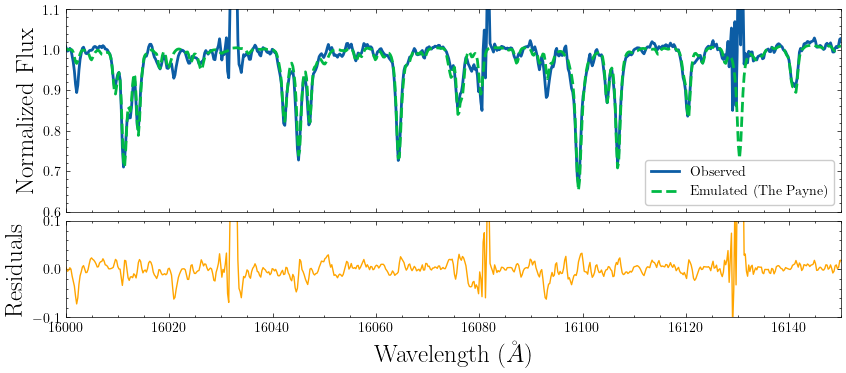

In [5]:
idx = 41
overlay_two_spec(wave_grid, 
                denormalize(obs_batch['x'][idx]),
                denormalize(synth_batch['x'][idx].data),
                label1 = 'Observed',
                label2 = 'Emulated (The Payne)',
                ylim=(0.6, 1.1))

```{note} 

Vary `idx` to view reconstructions from other spectra within the dataset.

```


Next, we will compare this with reconstructions from the network.

### $\chi_{synth}\rightarrow \chi_{synth}$


```{figure} images/synthsynth.png
---
height: 425px
width: 450px
name: synthsynth
---

```


In [6]:
# Evaluate validation set
model.eval_mode()
    
with torch.no_grad():
    # Encoding
    z_sh_synth = model.synth_to_z(synth_batch['x'])

    # Within-domain Reconstruction (Autoencoding)
    x_synth_synth = model.z_to_synth(z_sh_synth)

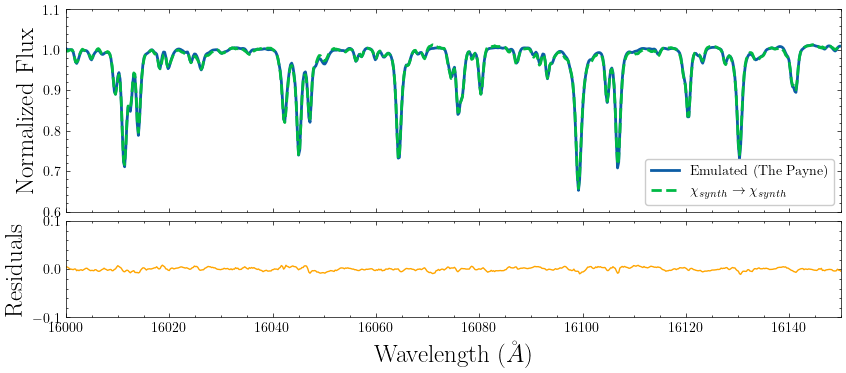

In [7]:
overlay_two_spec(wave_grid, 
                denormalize(synth_batch['x'][idx].data),
                denormalize(x_synth_synth[idx].data),
                label1 = 'Emulated (The Payne)',
                label2 = '$\\chi_{synth}\\rightarrow \\chi_{synth}$',
                ylim=(0.6, 1.1))

### $\chi_{obs}\rightarrow \chi_{obs}$


```{figure} images/obsobs.png
---
height: 425px
width: 450px
name: obsobs
---

```

In [8]:
# Evaluate validation set
model.eval_mode()
    
with torch.no_grad():
    # Encoding
    z_sh_obs, z_sp_obs = model.obs_to_z(obs_batch['x'])

    # Within-domain Reconstruction (Autoencoding)
    x_obs_obs = model.z_to_obs(z_sh_obs, z_sp_obs)

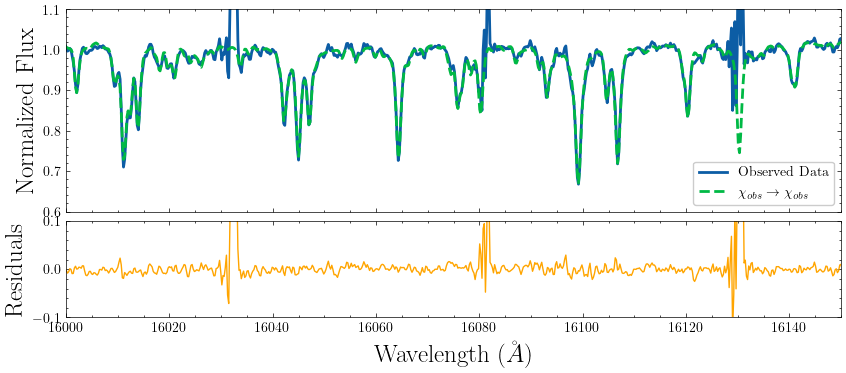

In [9]:
overlay_two_spec(wave_grid, 
                denormalize(obs_batch['x'][idx].data),
                denormalize(x_obs_obs[idx].data),
                label1 = 'Observed Data',
                label2 = '$\\chi_{obs}\\rightarrow \\chi_{obs}$',
                ylim=(0.6, 1.1))

While subtle, there are indeed differences between the $\chi_{obs}\rightarrow \chi_{obs}$ and the '$\chi_{synth}\rightarrow \chi_{synth}$' spectra.

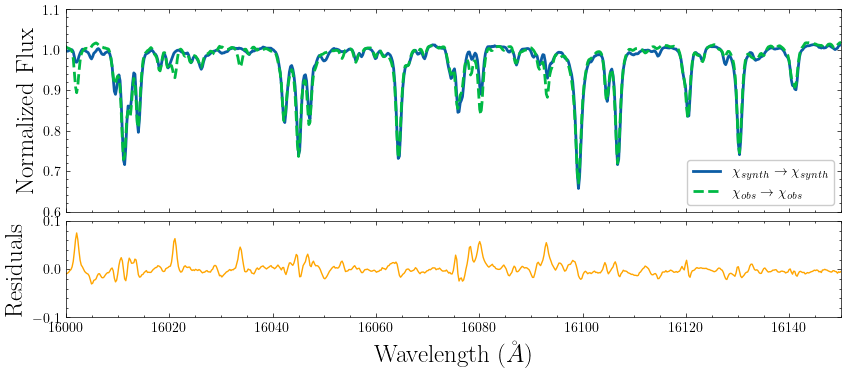

In [10]:
overlay_two_spec(wave_grid, 
                denormalize(x_synth_synth[idx].data),
                denormalize(x_obs_obs[idx].data),
                label1 = '$\\chi_{synth}\\rightarrow \\chi_{synth}$',
                label2 = '$\\chi_{obs}\\rightarrow \\chi_{obs}$',
                ylim=(0.6, 1.1))

### $\chi_{synth}\rightarrow \chi_{obs}$

```{figure} images/synthobs.png
---
height: 425px
width: 450px
name: synthobs
---

```

In [11]:
# Evaluate validation set
model.eval_mode()
    
with torch.no_grad():
    # Encoding
    z_sh_synth = model.synth_to_z(synth_batch['x'])
    z_sh_obs, z_sp_obs = model.obs_to_z(obs_batch['x'])

    # Cross-domain Mapping
    x_synth_obs = model.z_to_obs(z_sh_synth, z_sp_obs) # 𝜒𝑠𝑦𝑛𝑡ℎ→𝜒𝑜𝑏𝑠

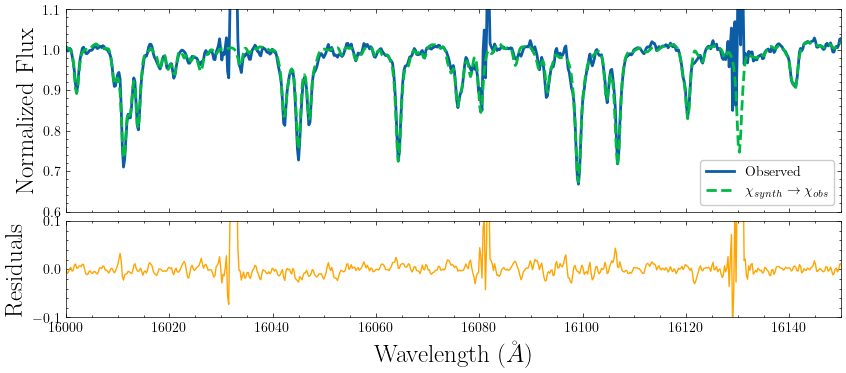

In [12]:
overlay_two_spec(wave_grid, 
                denormalize(obs_batch['x'][idx]),
                denormalize(x_synth_obs[idx].data),
                label1 = 'Observed',
                label2 = '$\\chi_{synth}\\rightarrow \\chi_{obs}$',
                ylim=(0.6, 1.1))

### $\chi_{obs}\rightarrow \chi_{synth}$

```{figure} images/obssynth.png
---
height: 425px
width: 450px
name: obssynth
---

```

In [13]:
# Evaluate validation set
model.eval_mode()
    
with torch.no_grad():
    # Encoding
    z_sh_obs, _ = model.obs_to_z(obs_batch['x'])

    # Cross-domain Mapping
    x_obs_synth = model.z_to_synth(z_sh_obs) # 𝜒𝑜𝑏𝑠→𝜒𝑠𝑦𝑛𝑡ℎ 

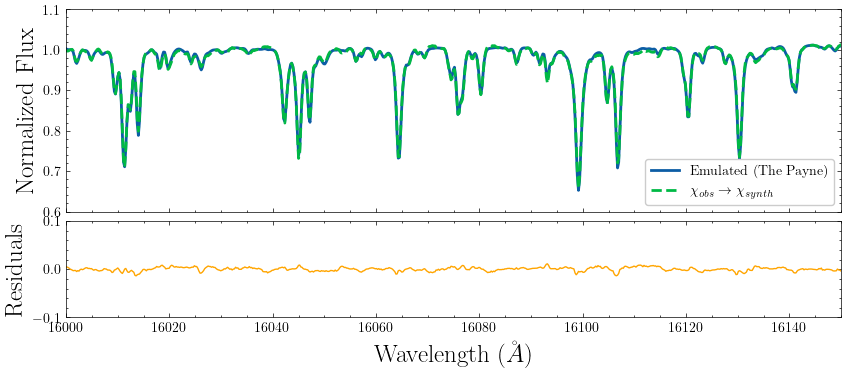

In [14]:
overlay_two_spec(wave_grid, 
                denormalize(synth_batch['x'][idx].data),
                denormalize(x_obs_synth[idx].data),
                label1 = 'Emulated (The Payne)',
                label2 = '$\\chi_{obs}\\rightarrow \\chi_{synth}$',
                ylim=(0.6, 1.1))

### $\chi_{synth}\rightarrow \chi_{obs} \rightarrow \chi_{synth}$

`````{admonition} Exercise
1. Fill in the blanks in the code block below to generate the mapping of $\chi_{synth}\rightarrow \chi_{obs} \rightarrow \chi_{synth}$, which yields the synthetic spectrum `x_synth_obs_synth`.
2. Do the same for $\chi_{obs}\rightarrow \chi_{synth} \rightarrow \chi_{obs}$. The first split latent variable containing information that is unique to the observed domain (namely `z_sp_obs`) should be used to cycle-reconstruct `x_obs_synth_obs` .

`````

In [ ]:
# Evaluate validation set
model.eval_mode()
    
with torch.no_grad():
    # Encoding
    z_sh_synth = model.synth_to_z(synth_batch['x'])
    z_sh_obs, z_sp_obs = model.obs_to_z(obs_batch['x'])

    # Cross-domain Mapping
    x_synth_obs = model.z_to_obs(z_sh_synth, z_sp_obs) # 𝜒𝑠𝑦𝑛𝑡ℎ→𝜒𝑜𝑏𝑠

    # Cycle-Reconstruction: Encoding Cross-domain Mapping to Latent Variable
    z_sh_synth_obs, z_sp_synth_obs = # Your Code Here 

    # Cycle-Reconstruction: Latent Variable to Mapping
    x_synth_obs_synth = # Your Code Here  # 𝜒𝑠𝑦𝑛𝑡ℎ→𝜒𝑜𝑏𝑠→𝜒𝑠𝑦𝑛𝑡ℎ

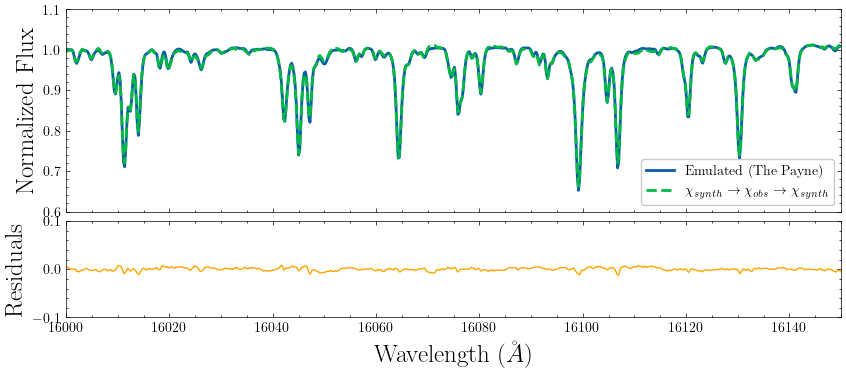

In [16]:
overlay_two_spec(wave_grid, 
                denormalize(synth_batch['x'][idx].data),
                denormalize(x_synth_obs_synth[idx].data),
                label1 = 'Emulated (The Payne)',
                label2 = '$\\chi_{synth}\\rightarrow \\chi_{obs} \\rightarrow \\chi_{synth}$',
                ylim=(0.6, 1.1))


### $\chi_{obs}\rightarrow \chi_{synth} \rightarrow \chi_{obs}$

In [ ]:
# Evaluate validation set
model.eval_mode()
    
with torch.no_grad():
    # Encoding
    z_sh_obs, z_sp_obs = model.obs_to_z(obs_batch['x'])
    # Cross-domain Mapping
    x_obs_synth = model.z_to_synth(z_sh_obs) # 𝜒𝑜𝑏𝑠→𝜒𝑠𝑦𝑛𝑡ℎ 
    
    # Cycle-Reconstruction: Encoding Cross-domain Mapping to Latent Variable
    z_sh_obs_synth = # Your Code Here 
    
    # Cycle-Reconstruction: Latent Variable to Mapping
    x_obs_synth_obs = # Your Code Here   #  𝜒𝑜𝑏𝑠→𝜒𝑠𝑦𝑛𝑡ℎ→𝜒𝑜𝑏𝑠 

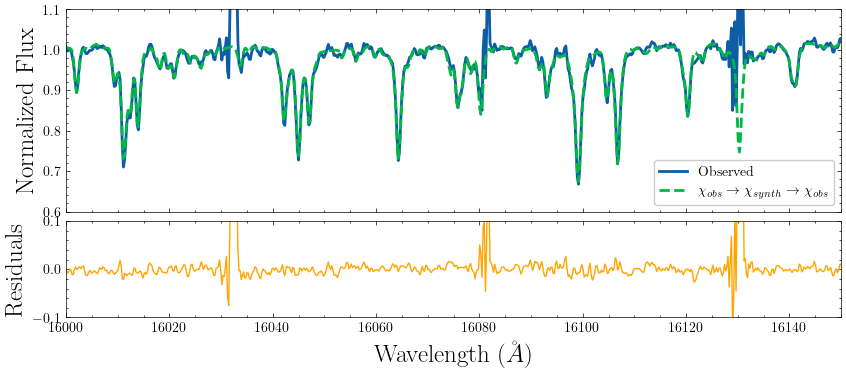

In [12]:
overlay_two_spec(wave_grid, 
                denormalize(obs_batch['x'][idx]),
                denormalize(x_obs_synth_obs[idx].data),
                label1 = 'Observed',
                label2 = '$\\chi_{obs}\\rightarrow \\chi_{synth} \\rightarrow \\chi_{obs}$',
                ylim=(0.6, 1.1))

## Representation Consistency

We can examine the consistency of how spectra are represented by looking at t-SNE projections of 
- The spectra directly ($\chi$)
- Their encoded representations ($\mathcal{Z}$)

In [61]:
from sklearn.manifold import TSNE

def plot_tsne(data_a, data_b, perplex, label1 = None, label2 = None):

    m = len(data_a)

    # Combine data
    t_data = np.row_stack((data_a,data_b))

    # Convert data to float64 matrix. float64 is need for bh_sne
    t_data = np.asarray(t_data).astype('float64')
    t_data = t_data.reshape((t_data.shape[0], -1))

    # Run t-SNE    
    vis_data = TSNE(n_components=2, perplexity=perplex).fit_transform(t_data)
    
    # Separate 2D into x and y axes information
    vis_x_a = vis_data[:m, 0]
    vis_y_a = vis_data[:m, 1]
    vis_x_b = vis_data[m:, 0]
    vis_y_b = vis_data[m:, 1]
    
    fig = plt.figure(figsize=(8,5))
    ax1 = fig.add_subplot(111)
    
    ax1.scatter(vis_x_a, vis_y_a, marker='o', c='cornflowerblue', alpha=0.2, label=label1)
    ax1.scatter(vis_x_b, vis_y_b, marker='o', c='firebrick', alpha=0.2, label=label2)
    
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2'); ax1.set_title('t-SNE')
    ax1.legend(frameon=1, framealpha=1)

The difference in the distribution between the 2D manifold of the synthetic and observed spectra shows the synthetic gap.

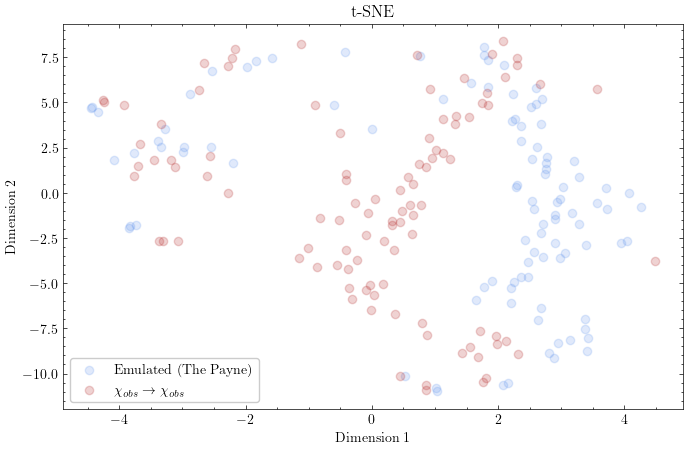

In [62]:
plot_tsne(synth_batch['x'].data.numpy(), x_obs_obs.data.numpy(), perplex=50,
         label1 = 'Emulated (The Payne)',
         label2 = '$\\chi_{obs}\\rightarrow \\chi_{obs}$')

The mapping $\chi_{synth}\rightarrow \chi_{obs}$ by `Cycle-SN` results in spectra whose distribution on the 2D manifold is identical to observations.

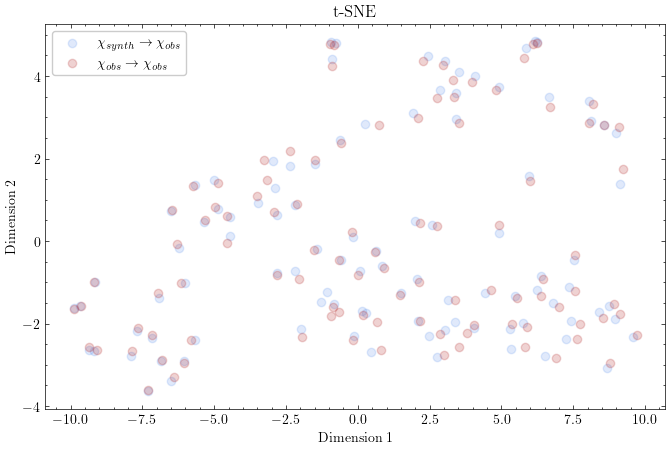

In [63]:
plot_tsne(x_synth_obs.data.numpy(), x_obs_obs.data.numpy(), perplex=50,
         label1 = '$\\chi_{synth}\\rightarrow \\chi_{obs}$',
         label2 = '$\\chi_{obs}\\rightarrow \\chi_{obs}$')

At the same time, the similarity in distribution of the mapped $\mathcal{Z}$ for both synthetic and observed spectra in latent space indicates that their encoded representations are identical. 

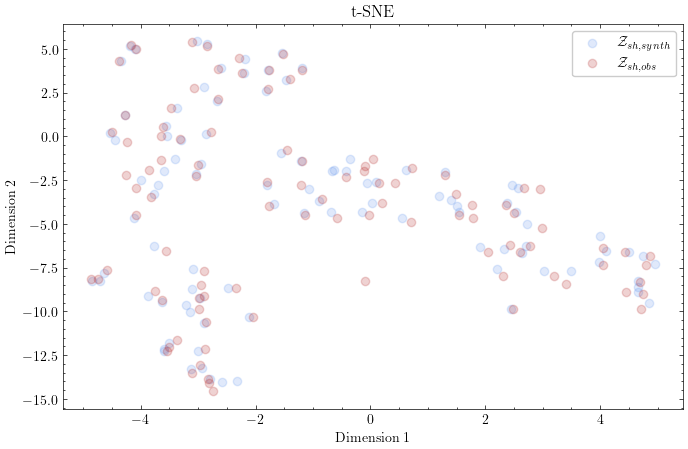

In [64]:
plot_tsne(z_sh_synth.data.numpy(), z_sh_obs.data.numpy(), perplex=50,
         label1 = '$\\mathcal{Z}_{sh, synth}$',
         label2 = '$\\mathcal{Z}_{sh, obs}$')

## Sensitivity Analyses 


To observe the sensitivity of the generative aspect of the network, we can perform a sensitivity analysis similar to that in [](content:references:spectra_part3). We examine the network's **Jacobian matrix**, which tells us the first order partial derivatives of each output (the pixels) with respect to each input (the labels).

Because the synthetic emulator uses *The Payne* and is thus differentiable, $x_{synth}=Payne(\mathbf{y})$, such that the Jacobian can be written as

$$
\mathbf{J_{synth}}(\mathbf{y}) = \begin{bmatrix}
   \frac{\partial x_{synth_{1}}}{\partial y_{1}} &
   \cdots  & \frac{\partial x_{synth_{1}}}{\partial y_{n}} \\
   \vdots & \ddots & \vdots \\
   \frac{\partial x_{synth_{_m}}}{\partial y_{1}} &
   \cdots & \frac{\partial x_{synth_{m}}}{\partial y_{n}}
\end{bmatrix}(\mathbf{y}) .
$$

In a similar fashion, we can compute the sensitivity in the observed domain, $\mathbf{J_{obs}}$.

```{admonition} Jacobian Matrices Across Domains
:class: tip

- Which Jacobian matrix is expected to contain more detailed spectral sensitivity information — $\mathbf{J_{\text{synth}}}$ or $\mathbf{J_{\text{obs}}}$? Why?
- In what ways does the Jacobian structure differ between synthetic and observed domains?

```


### A Toy Example

An illustrative example, as described in the [original study](https://github.com/teaghan/Cycle_SN), performs the following:
- Masks spectral features of model spectra to create a **new synthetic domain**. 
- Uses the original model spectra with added noise as the **observed domain**.

A version of `Cycle-SN` pre-trained on data from these domains will be used in this example. 


In [68]:
model_name = 'new_lines_10perc'

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']

# Data Files
data_file_obs = data_dir + '/csn_apogee_mock_test.h5'

# Defining Model and Loading Pre-trained Weights into it"
model = CycleSN(architecture_config, emulator_fn, use_cuda=0)
model_filename =  os.path.join(model_dir,'new_lines_1.pth.tar')
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['cycle_model'])
model.eval_mode()

# Load line mask that masks spectral features
line_mask = np.load(data_dir+'/mock_missing_lines.npz')['total_mask'] 
line_mask = torch.from_numpy(np.array(line_mask, dtype=np.uint8))

In the following, we define the label vector $\mathbf{y}$:

In [69]:
label_names = [
    "Teff", "Logg", "Vturb",
    "[C/H]", "[N/H]", "[O/H]", "[Na/H]", "[Mg/H]",
    "[Al/H]", "[Si/H]", "[P/H]", "[S/H]", "[K/H]",
    "[Ca/H]", "[Ti/H]", "[V/H]", "[Cr/H]", "[Mn/H]",
    "[Fe/H]", "[Co/H]", "[Ni/H]", "[Cu/H]", "[Ge/H]",
    "C12/C13", "Vmacro"]


labels = np.array([[4750., 2.5, 1.5, 
                        0., 0., 0., 0., 0.,
                        0., 0., 0., 0., 0., 
                        0., 0., 0., 0., 0.,
                        -2.5, 0., 0., 0., 0., 
                        7.5, 6.]])
ref_labels = torch.from_numpy(labels.astype(np.float32)) 

The following code snippet defines helper functions for predicting spectra.

```{note}
The mapping to $\chi_{obs}$ requires encoded information specific to the observational domain. To get a representative sample, we may take the average of the **split** encoding $\mathcal{Z}_{sp}$ of spectra from the observational domain.

    num_spec = 100

    # Create a batch of 'observed' spectra
    obs_dataset = CSNDataset(data_file_obs, dataset='val', x_mean=x_mean, 
                                 x_std=x_std, line_mask=None)
    obs_batch = obs_dataset.__getitem__(np.arange(num_spec)) 

    # Get an average z_split from the observations 
    z_split = torch.mean(model.obs_to_z(obs_batch['x'])[1], 0, keepdim=True)

```

For simplicity, the derivatives for the Jacobian will be calculated as first order (linear) derivatives of labels $\mathbf{y}$ relative to the pixel flux $\mathbf{x}$.

In [72]:
def y_to_synth(y):
    
    # Produce synthetic spectrum
    x = model.emulator(y)
    
    # Mask lines
    x[:,line_mask==1]=1.
    
    # Return last 7167 pixels
    return x[:,47:]

def y_to_synth_to_synth(y):

    # Produce synthetic spectrum with masked lines
    x = y_to_synth(y)
    
    # Normalize
    x = (x-x_mean)/x_std
    
    # Encode the synthetic spectrum
    z = model.synth_to_z(x)

    # Decode the latent variables into the synthetic domain
    x = model.z_to_synth(z)
    
    # Return to the regular continuum level and scale
    x = x*x_std + x_mean
    
    return x

def y_to_synth_to_obs(y):

    # Produce synthetic spectrum with masked lines
    x = y_to_synth(y)
    
    # Normalize
    x = (x-x_mean)/x_std

    # Encode the synthetic spectrum
    z = model.synth_to_z(x)

    # Decode the latent variables into the observed domain
    z_sp = torch.cat(len(y)*[z_split])
    x = model.z_to_obs(z, z_sp)

    # Return to the regular continuum level and scale
    x = x*x_std + x_mean
    return x


num_spec = 100

# Create a batch of 'observed' spectra
obs_dataset = CSNDataset(data_file_obs, dataset='val', x_mean=x_mean, 
                             x_std=x_std, line_mask=None)
obs_batch = obs_dataset.__getitem__(np.arange(num_spec)) 

# Get an average z_split from the observations 
z_split = torch.mean(model.obs_to_z(obs_batch['x'])[1], 0, keepdim=True)

# Scale labels for emulator input
y = (ref_labels - model.y_min)/(model.y_max-model.y_min) - 0.5

with torch.no_grad():
    # Create a synthetic spectrum
    x_synth = y_to_synth(y)

    # Create observed spectrum
    x_obs = y_to_synth_to_obs(y)

In [81]:
# Vectors to collect
jac_synth  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))
jac_synthobs  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))

for ele_index in range(25):

    # Deviate reference labels
    deviate_labels = torch.clone(ref_labels)
    deviate_labels[0,ele_index] += 0.05

    # Scale labels for emulator input
    y = (ref_labels.to(model.y_min.device) - model.y_min)/(model.y_max-model.y_min) - 0.5
    y_dev = (deviate_labels.to(model.y_min.device) - model.y_min)/(model.y_max-model.y_min) - 0.5

    # Create a synthetic spectrum
    x_synth = y_to_synth(y).data.cpu().numpy()
    x_synth_dev = y_to_synth(y_dev).data.cpu().numpy()

    # Create observed spectrum
    x_synthobs = y_to_synth_to_obs(y).data.cpu().numpy()
    x_synthobs_dev = y_to_synth_to_obs(y_dev).data.cpu().numpy()

    # Calculate difference
    jac_synth[:,ele_index] = x_synth_dev-x_synth
    jac_synthobs[:,ele_index] = x_synthobs_dev-x_synthobs
    
# Only select abundances
jac_synthobs = jac_synthobs[:,3:-2]
jac_synth = jac_synth[:,3:-2]    
jac_diff = jac_synthobs - jac_synth

In [87]:
def plot_jacobian_diff(ele_indices, ele_labels, wave_grid, wave_grid_full, 
                       x_obs, x_synth, jac_diff, min_wave=15880, max_wave=16230):
    """
    Plot CycleSN synthetic, observed, residual spectrum, and Jacobian differences for selected elements.
    
    Parameters:
        ele_indices (list): indices of elements to plot Jacobians for
        ele_labels (list): full list of element abundance labels
        wave_grid (np.array): wavelength array (47 onward)
        wave_grid_full (np.array): full wavelength array
        x_obs (Tensor): observed spectrum (Torch tensor)
        x_synth (np.array): synthetic spectrum
        jac_diff (np.array): Jacobian difference array (wavelength x abundance)
    """

    plt.close('all')
    ele_colors = ['teal', 'firebrick', 'goldenrod', 'darkblue', 'purple', 'orange']

    wave = wave_grid
    x_resid = (x_obs.data.numpy() - x_synth)
    x_resid = np.concatenate((np.zeros((1,47)), x_resid), 1)

    fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)

    # Panel 1: Synthetic
    axes[0].plot(wave, x_synth[0], c='maroon')
    axes[0].set_ylabel(r'Flux', fontsize=22)

    # Panel 2: Observed
    axes[1].plot(wave, x_obs[0].data.numpy(), c='coral')
    axes[1].set_ylabel(r'Flux', fontsize=22)

    # Panel 3: Residual
    axes[2].plot(wave_grid_full, x_resid[0], c='gray', alpha=0.7)
    axes[2].set_ylabel(r'Flux', fontsize=22)

    # Panel 4: Jacobian Difference
    for i, ele_index in enumerate(ele_indices):
        color = ele_colors[i % len(ele_colors)]
        axes[3].plot(wave, jac_diff[:, ele_index], label=ele_labels[ele_index], c=color)
    axes[3].legend(loc='upper center', ncol=len(ele_indices), fontsize=15)
    axes[3].set_ylabel(r'$\Delta\, \partial F/\partial [X/H]$', fontsize=22)

    axes[0].set_xlim((min_wave, max_wave))
    axes[0].set_ylim((0.5, 1.1))
    axes[2].set_ylim((-0.5, 0.1))
    axes[3].set_ylim((-0.01, 0.01))
    axes[3].set_xlabel(r'Wavelength ($\AA$)', fontsize=20)

    titles = [
        r'$\mathbf{x_{synth}}=\mathrm{Payne}(\mathbf{y})$',
        r'$T_{\mathrm{synth}\rightarrow \mathrm{obs}}(\mathbf{x_{synth}})$',
        r'$T_{\mathrm{synth} \rightarrow \mathrm{obs}}(\mathbf{x_{synth}})-\mathbf{x_{synth}}$',
        r'$\frac{\partial T_{\mathrm{synth} \rightarrow \mathrm{obs}}}{\partial y_j} - \frac{\partial \mathrm{Payne}}{\partial y_j}$'
    ]
    for ax, title in zip(axes, titles):
        ax.set_title(title, fontsize=20)
        ax.tick_params(labelsize=15)

    plt.tight_layout()
    plt.show()

```{admonition} Exercise - Spectral Line Discovery
:class: tip

Suppose we know that an observed and a synthetic spectrum supposedly have the same elemental abundances but have subtle differences due to the synthetic gap. The plot below highlights a spectral region where the `CycleSN`-translated spectrum shows an several absorption features not present in the synthetic spectrum. This suggests that the **observational domain** contains information absent from the synthetic domain.

Can we identify **which element** is likely responsible?


:::{hint}
:class: dropdown
- The final panel shows the **difference in Jacobians**: $\mathbf{J_{diff} \equiv J_{obs} - J_{synth}}$. This is how sensitive the observed and synthetic models are to individual element abundances.
- A sharp peak in `∂Flux/∂[X/H]` near the unknown feature can signal that element **X** is responsible.

:::


```


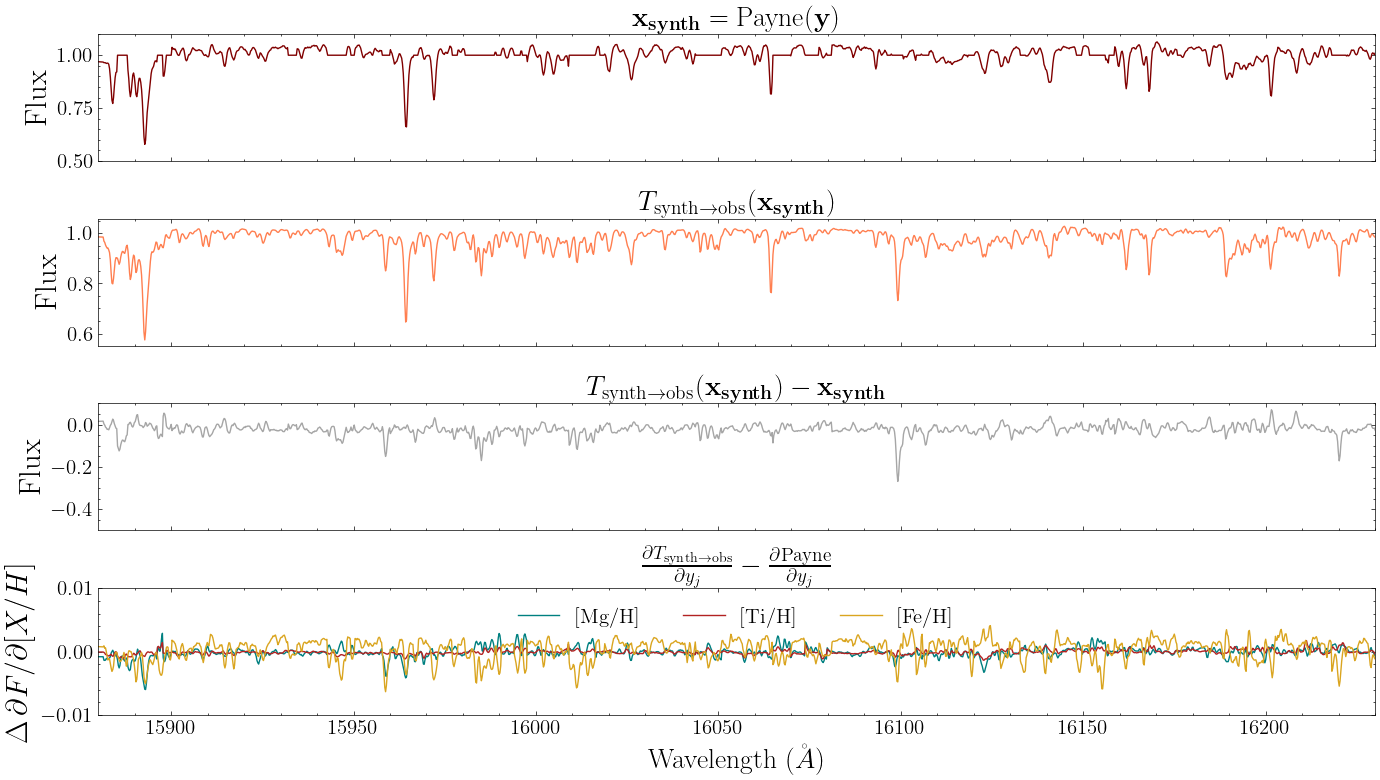

In [98]:
elem_labels = ['[C/H]', '[N/H]', '[O/H]', '[Na/H]', '[Mg/H]',
               '[Al/H]', '[Si/H]', '[P/H]', '[S/H]', '[K/H]',
               '[Ca/H]', '[Ti/H]', '[V/H]', '[Cr/H]', '[Mn/H]',
               '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]']

plot_indices = [4, 11, 15,] # indices of elem_labels to plot

plot_jacobian_diff(plot_indices, elem_labels, wave, wave_grid, x_obs, x_synth, jac_diff)